In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Load the data
multi_funds_df = pd.read_csv('cotas_tradicional.csv')
quant_funds_df = pd.read_csv('cotas_quant.csv')

multi_funds_df = multi_funds_df.set_index('Data')
quant_funds_df = quant_funds_df.set_index('Data')

quant_funds_df.columns = [col.split(' ')[0] for col in quant_funds_df.columns]
multi_funds_df.columns = [col.split(' ')[0] for col in multi_funds_df.columns]

quant_funds_df = quant_funds_df.dropna(axis=1)
multi_funds_df = multi_funds_df.dropna(axis=1)

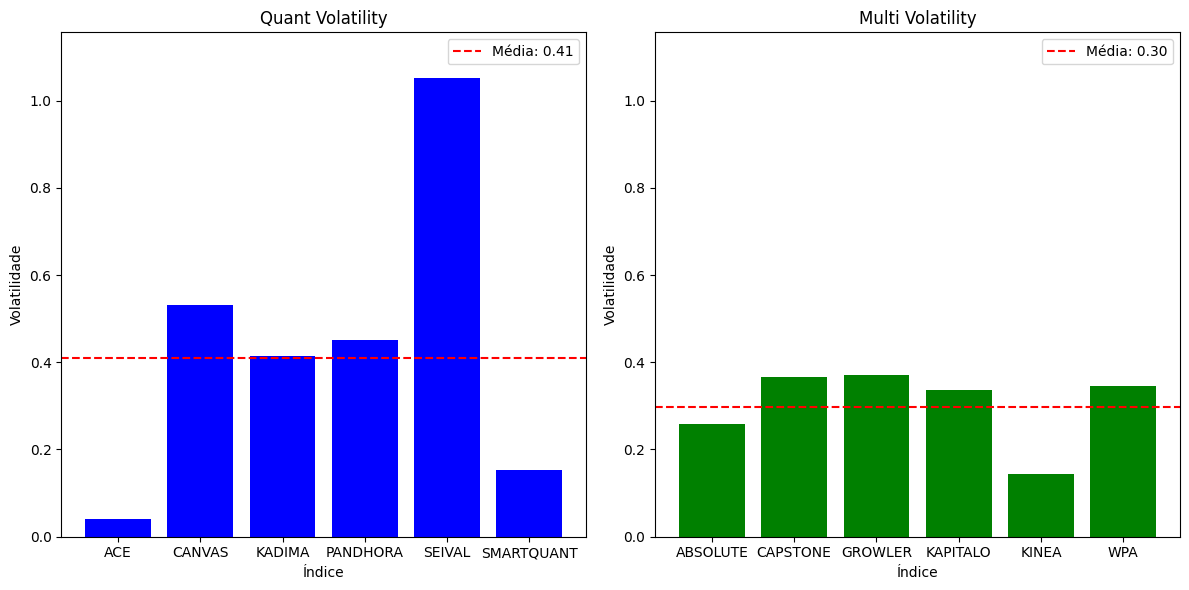

In [ ]:
quant_volatility = quant_funds_df.std()
multi_volatility = multi_funds_df.std()

quant_vol_avg = quant_volatility.mean()
multi_vol_avg = multi_volatility.mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

y_max = quant_volatility.max()* 1.1

# Gráfico de barras para quant_volatility
ax1.bar(quant_volatility.index, quant_volatility, color='blue')
ax1.axhline(y=quant_vol_avg, color='red', linestyle='--', label=f'Média: {quant_vol_avg:.2f}')
ax1.set_title('Quant Volatility')
ax1.set_xlabel('Índice')
ax1.set_ylabel('Volatilidade')
ax1.set_ylim(0, y_max)
ax1.legend()

# Gráfico de barras para multi_volatility
ax2.bar(multi_volatility.index, multi_volatility, color='green')
ax2.axhline(y=multi_vol_avg, color='red', linestyle='--', label=f'Média: {multi_vol_avg:.2f}')
ax2.set_title('Multi Volatility')
ax2.set_xlabel('Índice')
ax2.set_ylabel('Volatilidade')
ax2.set_ylim(0, y_max)
ax2.legend()

# Exibir o gráfico
plt.tight_layout()
plt.show()

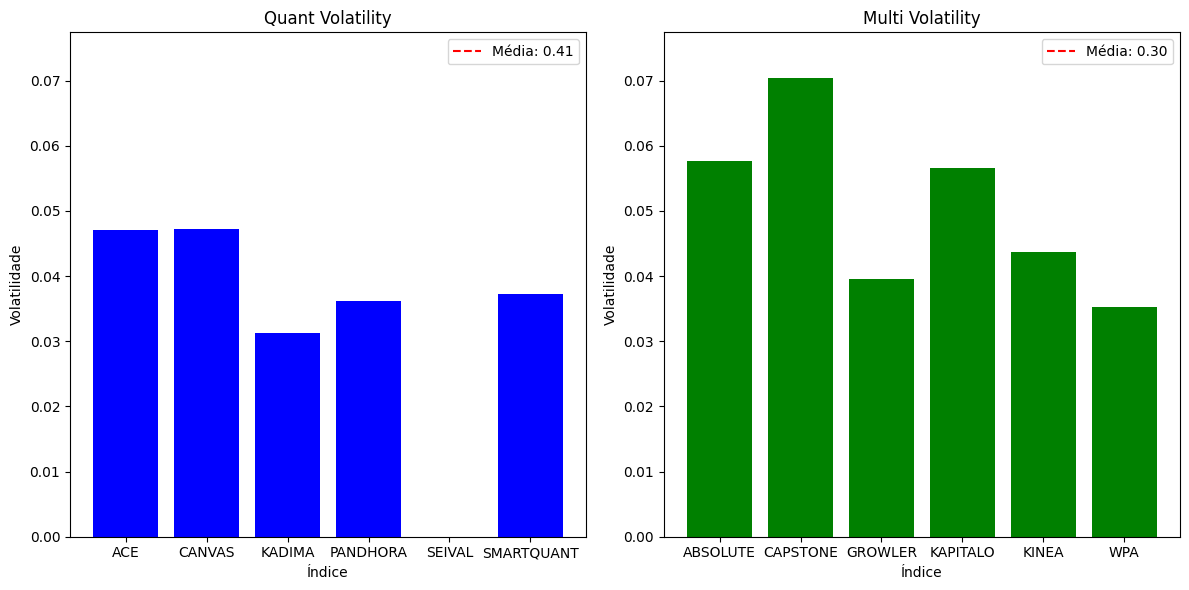

In [ ]:
quant_return_avg = quant_funds_df.mean()
multi_return_avg = multi_funds_df.mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

y_max = multi_return_avg.max()* 1.1

# Gráfico de barras para quant_volatility
ax1.bar(quant_volatility.index, quant_return_avg, color='blue')
ax1.axhline(y=quant_vol_avg, color='red', linestyle='--', label=f'Média: {quant_vol_avg:.2f}')
ax1.set_title('Quant Volatility')
ax1.set_xlabel('Índice')
ax1.set_ylabel('Volatilidade')
ax1.set_ylim(0, y_max)
ax1.legend()

# Gráfico de barras para multi_volatility
ax2.bar(multi_volatility.index, multi_return_avg, color='green')
ax2.axhline(y=multi_vol_avg, color='red', linestyle='--', label=f'Média: {multi_vol_avg:.2f}')
ax2.set_title('Multi Volatility')
ax2.set_xlabel('Índice')
ax2.set_ylabel('Volatilidade')
ax2.set_ylim(0, y_max)
ax2.legend()

# Exibir o gráfico
plt.tight_layout()
plt.show()

In [ ]:
def get_market_returns(start_date, end_date):
    """Obtém os retornos do Ibovespa"""
    ibov = yf.download('^BVSP', start=start_date, end=end_date)['Adj Close']
    return ibov.pct_change().dropna()

start_date = '2021-12-31'
end_date = max(quant_funds_df.index.max(), multi_funds_df.index.max())
market_returns = get_market_returns(start_date, end_date)

def sincronizar_index(df_principal, *dataframes):
    dataframes_sincronizados = []
    for df in dataframes:
        # Reindexa o dataframe com base no índice do dataframe principal, preenchendo valores ausentes com 0
        df_sincronizado = df.reindex(df_principal.index, fill_value=0)
        dataframes_sincronizados.append(df_sincronizado)
    return dataframes_sincronizados

market_returns, quant_funds_df = sincronizar_index(multi_funds_df, market_returns, quant_funds_df)

[*********************100%***********************]  1 of 1 completed


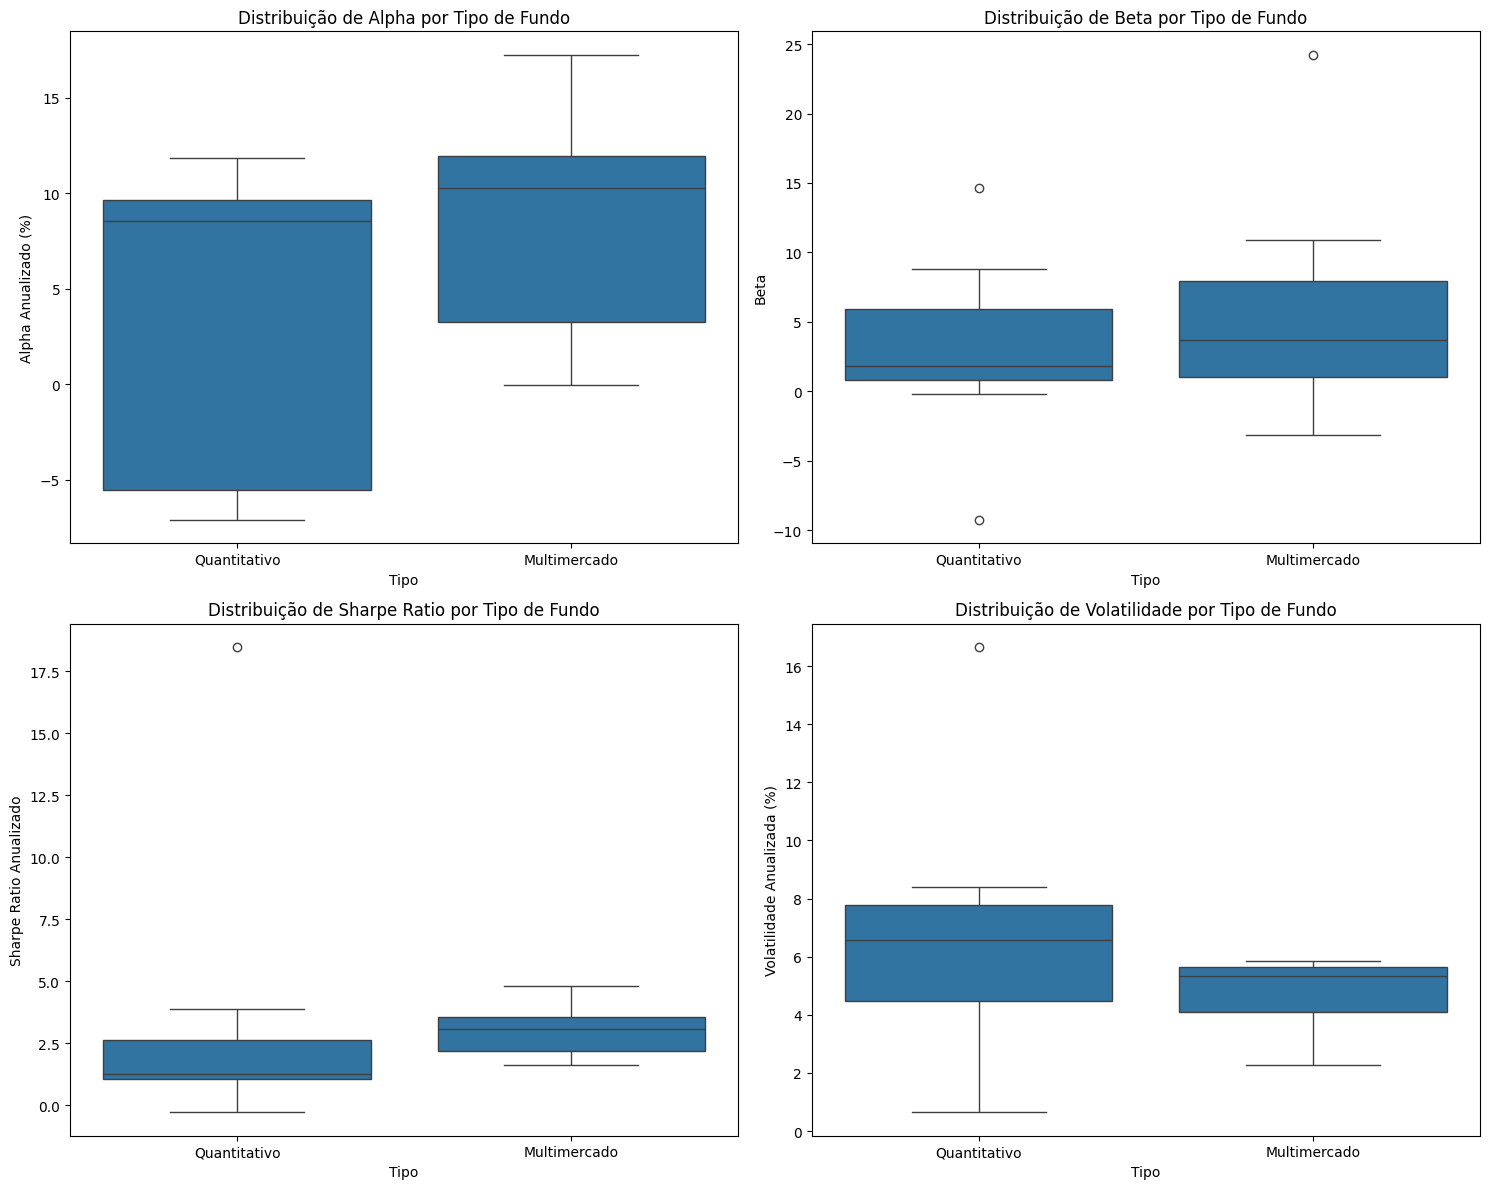


Estatísticas Resumidas:
               Alpha                             Beta                  \
                mean     std     min      max    mean     std     min   
Tipo                                                                    
Multimercado  8.2790  6.5336 -0.0396  17.2618  6.0882  9.1045 -3.1871   
Quantitativo  3.0663  8.6844 -7.1069  11.8590  2.9384  7.4365 -9.2756   

                           R²                          Sharpe                  \
                  max    mean     std     min     max    mean     std     min   
Tipo                                                                            
Multimercado  24.2450  0.4024  0.4528  0.0088  1.0000  2.9900  1.1224  1.6179   
Quantitativo  14.6047  0.3534  0.4532  0.0025  0.9852  3.8369  6.5714 -0.2931   

                          Vol                           
                  max    mean     std     min      max  
Tipo                                                    
Multimercado   4.8082  4.7109  1

In [ ]:
from scipy import stats
from sklearn.linear_model import LinearRegression

def style_analysis(fund_returns, market_returns):
    """
    Realiza a análise de estilo do fundo usando regressão linear
    Retorna alpha, beta e R²
    """
    X = market_returns.values.reshape(-1, 1)
    y = fund_returns.values

    model = LinearRegression()
    model.fit(X, y)

    alpha = model.intercept_
    beta = model.coef_[0]
    r_squared = model.score(X, y)

    return alpha, beta, r_squared

def analyze_funds(funds_df, market_returns):
    """Analisa todos os fundos em um DataFrame"""
    results = []

    for fund in funds_df.columns:
        # Alinhar as datas dos retornos
        aligned_returns = pd.concat([funds_df[fund], market_returns], axis=1).dropna()

        alpha, beta, r_squared = style_analysis(aligned_returns.iloc[:, 0],
                                              aligned_returns.iloc[:, 1])

        results.append({
            'Fundo': fund,
            'Alpha': alpha * 252,  # Anualizado
            'Beta': beta,
            'R²': r_squared,
            'Sharpe': np.mean(aligned_returns.iloc[:, 0]) / np.std(aligned_returns.iloc[:, 0]) * np.sqrt(252),
            'Vol': np.std(aligned_returns.iloc[:, 0]) * np.sqrt(252)
        })

    return pd.DataFrame(results)



# Realizar análise de estilo
quant_analysis = analyze_funds(quant_funds_df, market_returns)
multi_analysis = analyze_funds(multi_funds_df, market_returns)

# Adicionar coluna de tipo de fundo
quant_analysis['Tipo'] = 'Quantitativo'
multi_analysis['Tipo'] = 'Multimercado'

# Combinar resultados
all_results = pd.concat([quant_analysis, multi_analysis])

# Criar figura com subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Alpha
sns.boxplot(data=all_results, x='Tipo', y='Alpha', ax=axes[0,0])
axes[0,0].set_title('Distribuição de Alpha por Tipo de Fundo')
axes[0,0].set_ylabel('Alpha Anualizado (%)')

# Plot 2: Beta
sns.boxplot(data=all_results, x='Tipo', y='Beta', ax=axes[0,1])
axes[0,1].set_title('Distribuição de Beta por Tipo de Fundo')
axes[0,1].set_ylabel('Beta')

# Plot 3: Sharpe
sns.boxplot(data=all_results, x='Tipo', y='Sharpe', ax=axes[1,0])
axes[1,0].set_title('Distribuição de Sharpe Ratio por Tipo de Fundo')
axes[1,0].set_ylabel('Sharpe Ratio Anualizado')

# Plot 4: Volatilidade
sns.boxplot(data=all_results, x='Tipo', y='Vol', ax=axes[1,1])
axes[1,1].set_title('Distribuição de Volatilidade por Tipo de Fundo')
axes[1,1].set_ylabel('Volatilidade Anualizada (%)')

plt.tight_layout()
plt.show()

# Estatísticas resumidas
summary_stats = all_results.groupby('Tipo').agg({
    'Alpha': ['mean', 'std', 'min', 'max'],
    'Beta': ['mean', 'std', 'min', 'max'],
    'R²': ['mean', 'std', 'min', 'max'],
    'Sharpe': ['mean', 'std', 'min', 'max'],
    'Vol': ['mean', 'std', 'min', 'max']
}).round(4)

print("\nEstatísticas Resumidas:")
print(summary_stats)

# Testes estatísticos
metrics = ['Alpha', 'Beta', 'Sharpe', 'Vol']
for metric in metrics:
    ttest = stats.ttest_ind(
        all_results[all_results['Tipo'] == 'Quantitativo'][metric],
        all_results[all_results['Tipo'] == 'Multimercado'][metric]
    )
    print(f"\nTeste t para {metric} entre grupos:")
    print(f"t-statistic: {ttest.statistic:.4f}")
    print(f"p-value: {ttest.pvalue:.4f}")